In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#STEP 1

#Import raw datasets and setting file paths

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math

#Paths

RAW_PATH1 = "/content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/dataset1.csv"
RAW_PATH2 = "/content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/dataset2.csv"

CLEANED_PATH1 = "/content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/dataset1_cleaned.csv"
CLEANED_PATH2 = "/content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/dataset2_cleaned.csv"


In [15]:
#STEP 2

#Loading Raw Data and attempt basic cleaning

#Cleaning Procedures:
#Loadin dataset1 which includes (bat landings) and dataset2 (30 min windows) from raw csv
#Convert 'time' based columns to real datetimes so we can compare the time frames
#Omit duplicate rows
#Ensuring every 'landing row' has valid start_time
#Setting up any negative hesitation time into 0

#Loading
df1_raw = pd.read_csv(RAW_PATH1)
df2_raw = pd.read_csv(RAW_PATH2)

#Parsing datetimes (invalid strings into NaT)
for c in ["start_time","rat_period_start","rat_period_end","sunset_time"]:
    if c in df1_raw.columns:
        df1_raw[c] = pd.to_datetime(df1_raw[c], errors="coerce")
if "time" in df2_raw.columns:
        df2_raw["time"] = pd.to_datetime(df2_raw["time"], errors="coerce")


#Omit duplicates
df1_raw = df1_raw.drop_duplicates().dropna(subset=["start_time"]).copy()
df2_raw = df2_raw.drop_duplicates().copy()

#Explicitly convert time columns to datetime objects for comparison
df2_raw['time'] = pd.to_datetime(df2_raw['time'], errors='coerce')
df1_raw['rat_period_start'] = pd.to_datetime(df1_raw['rat_period_start'], errors='coerce')
df1_raw['rat_period_end'] = pd.to_datetime(df1_raw['rat_period_end'], errors='coerce')


#Negative hesitation time to 0
if "bat_landing_to_food" in df1_raw.columns:
          df1_raw.loc[df1_raw["bat_landing_to_food"] < 0, "bat_landing_to_food"] = 0.0

print("RAW shapes -> dataset1:", df1_raw.shape, "| dataset2:", df2_raw.shape)

RAW shapes -> dataset1: (906, 12) | dataset2: (2123, 7)


/tmp/ipython-input-2822374536.py:19: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1_raw[c] = pd.to_datetime(df1_raw[c], errors="coerce")
/tmp/ipython-input-2822374536.py:19: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1_raw[c] = pd.to_datetime(df1_raw[c], errors="coerce")
/tmp/ipython-input-2822374536.py:19: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1_raw[c] = pd.to_datetime(df1_raw[c], errors="coerce")
/tmp/ipython-input-2822374536.py:19: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df1_r

In [6]:
#Step 2

#Clearning qualitative columns

#For the 'habit' column, we will only keep valid descriptive values and convert irrelevant values to "Unknown"
#We do the same process for other descriptive columns
#We are not omitting the entire rows to avoid lack of data

habit_map = {
    "pick": "bat feeding normally",
    "rat_pick": "bat feeding while a rat was present",
    "bat_and_pick": "bat feeding with another bat around",
    "bat_and_rat": "bat and rat interacting",
    "bat_fight": "bats fighting each other",
    "all_pick": "bats and rats all competing at once"
}
valid_habits = list(habit_map.keys())

#if 'habit' is valid or 'Unknown'; adding readable labels
if "habit" in df1_raw.columns:
    df1_raw["habit"] = df1_raw["habit"].where(df1_raw["habit"].isin(valid_habits), other="Unknown")
    df1_raw["habit_label"] = df1_raw["habit"].map(habit_map).fillna("Unknown")

#Following the same proces for other columns
def clean_qual_keep_row(series):
    s = series.astype("string")
    is_numlike = s.str.match(r'^\s*-?\d+(\.\d+)?\s*$')
    return s.where(~is_numlike, other="Unknown")

#Applying to dataset1's object column apart from 'habit' and 'habit_label'
for col in df1_raw.select_dtypes(include="object").columns:
    if col not in ["habit", "habit_label"]:
        df1_raw[col] = clean_qual_keep_row(df1_raw[col])

#Applying to dataset2 object columns
for col in df2_raw.select_dtypes(include="object").columns:
    df2_raw[col] = clean_qual_keep_row(df2_raw[col])

print("Habit categories after cleaning (dataset1):")
print(df1_raw["habit"].value_counts(dropna=False))


Habit categories after cleaning (dataset1):
habit
Unknown         684
pick            139
bat_fight        25
bat_and_pick     20
bat_and_rat      19
rat_pick         14
all_pick          5
Name: count, dtype: int64


In [7]:
#Step 4
#We will be exporting the cleaned dataset so that the master raw file and the cleaned files exist together (if future reference is needed)


df1_raw.to_csv(CLEANED_PATH1, index=False)
df2_raw.to_csv(CLEANED_PATH2, index=False)

print("Exported cleaned dataset1 ->", CLEANED_PATH1)
print("Exported cleaned dataset2 ->", CLEANED_PATH2)


Exported cleaned dataset1 -> /content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/dataset1_cleaned.csv
Exported cleaned dataset2 -> /content/drive/MyDrive/HIT140 - Group 60 - Assessment 2/dataset2_cleaned.csv


In [8]:
#Step 5

#Reloading and reparsing the cleaned datasets for the use of analysis


df1 = pd.read_csv(CLEANED_PATH1)
df2 = pd.read_csv(CLEANED_PATH2)

# Reparsing datetimes
for c in ["start_time","rat_period_start","rat_period_end","sunset_time"]:
    if c in df1.columns:
        df1[c] = pd.to_datetime(df1[c], errors="coerce")
if "time" in df2.columns:
    df2["time"] = pd.to_datetime(df2["time"], errors="coerce")

print("CLEANED (reloaded) shapes -> dataset1:", df1.shape, "| dataset2:", df2.shape)


CLEANED (reloaded) shapes -> dataset1: (906, 13) | dataset2: (2123, 7)


In [9]:
#Step 6

#Removing outliers (if any) using the Interquartile Range
#Using 1.5xIQR method


target = "bat_landing_to_food"
if target not in df1.columns:
    raise ValueError(f"Required column '{target}' not found in dataset1.")

vals = df1[target].dropna()
Q1, Q3 = vals.quantile([0.25, 0.75])
IQR = Q3 - Q1
low, high = Q1 - 1.5*IQR, Q3 + 1.5*IQR

before = len(df1)
df1 = df1[(df1[target] >= low) & (df1[target] <= high)].copy()
after = len(df1)

print(f"IQR bounds for '{target}': [{low:.2f}, {high:.2f}] | removed {before - after} outliers")
print("Rows remaining (dataset1 after IQR):", df1.shape[0])

IQR bounds for 'bat_landing_to_food': [-15.12, 27.88] | removed 88 outliers
Rows remaining (dataset1 after IQR): 818


In [10]:
#Step 7

#Feature Engineering rat's presence during landing
#splitting the variables into two groups which can be denoted as Present vs Absent

df1["rat_present_at_landing"] = (
    df1["rat_period_start"].notna()
    & df1["rat_period_end"].notna()
    & (df1["start_time"] >= df1["rat_period_start"])
    & (df1["start_time"] <= df1["rat_period_end"])
)

present = df1.loc[df1["rat_present_at_landing"] == True, target].dropna()
absent  = df1.loc[df1["rat_present_at_landing"] == False, target].dropna()

print("Group sizes > Rats PRESENT:", len(present), "| Rats ABSENT:", len(absent))


Group sizes > Rats PRESENT: 818 | Rats ABSENT: 0



Overall hesitation (sec):
count    818.000000
mean       5.695370
std        6.483649
min        0.010238
25%        1.000000
50%        3.000000
75%        8.000000
max       27.000000
Name: bat_landing_to_food, dtype: float64

By Rat Presence (count/mean/median/std):
                        count     mean  median       std
rat_present_at_landing                                  
True                      818  5.69537     3.0  6.483649

By Rat Presence × Habit (count/mean/median/std):
                                     count       mean  median        std
rat_present_at_landing habit                                            
True                   Unknown         630   4.838040     2.0   6.168054
                       bat_and_pick     17  11.655429    13.0   7.038174
                       bat_and_rat      14   4.808959     3.0   6.209531
                       bat_fight        22   7.095953     4.5   6.333021
                       pick            127   8.521125     6.0   6.2173

/tmp/ipython-input-1489643749.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([present, absent], labels=["Rats Present","Rats Absent"])


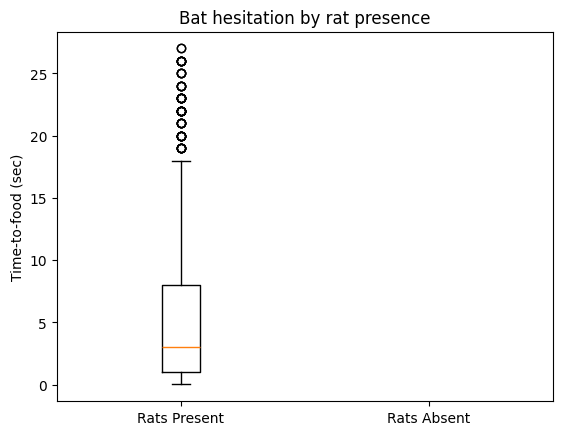

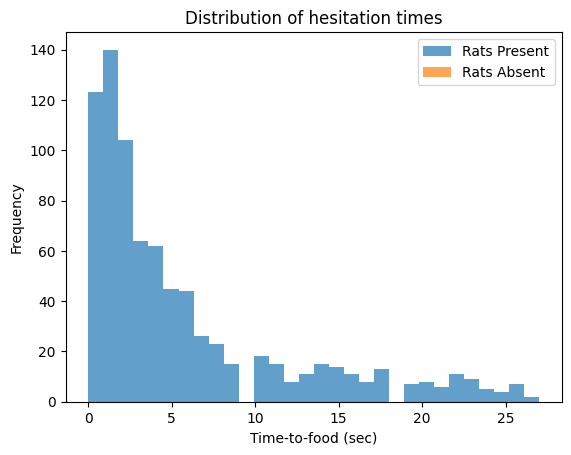

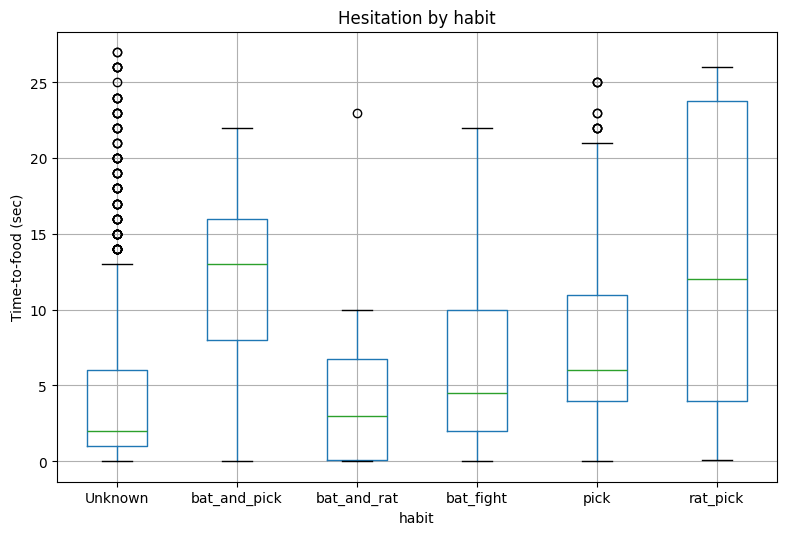

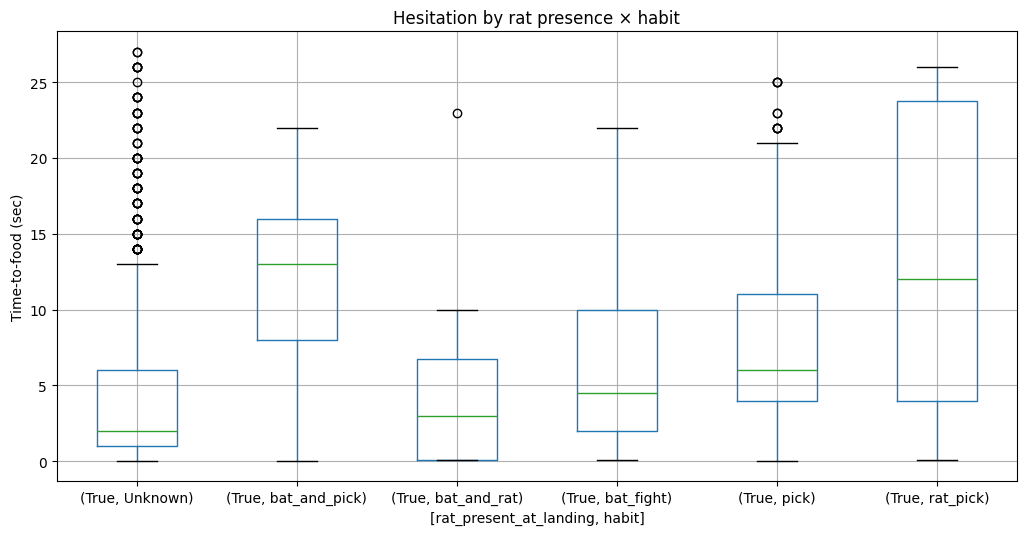

In [11]:
#Step 8

#Differential Statistical Analysis
#We will be plotting some diagrams for reference

#We will also group the data by habit for even a better understanding of the activities with different habits


#Summaries
print("\nOverall hesitation (sec):")
print(df1[target].describe())

print("\nBy Rat Presence (count/mean/median/std):")
print(df1.groupby("rat_present_at_landing")[target].agg(["count","mean","median","std"]))

if "habit" in df1.columns:
    print("\nBy Rat Presence × Habit (count/mean/median/std):")
    print(df1.groupby(["rat_present_at_landing","habit"])[target].agg(["count","mean","median","std"]))

#Boxplot: Present vs Absent
plt.boxplot([present, absent], labels=["Rats Present","Rats Absent"])
plt.ylabel("Time-to-food (sec)")
plt.title("Bat hesitation by rat presence")
plt.show()

#Histogram
plt.hist(present, bins=30, alpha=0.7, label="Rats Present")
plt.hist(absent,  bins=30, alpha=0.7, label="Rats Absent")
plt.xlabel("Time-to-food (sec)"); plt.ylabel("Frequency")
plt.title("Distribution of hesitation times")
plt.legend(); plt.show()

#Boxplot (Habit Wise)
if "habit" in df1.columns:
    df1.boxplot(column=target, by="habit", figsize=(9,6))
    plt.ylabel("Time-to-food (sec)")
    plt.title("Hesitation by habit")
    plt.suptitle(""); plt.show()

    # Presence × habit
    df1.boxplot(column=target, by=["rat_present_at_landing","habit"], figsize=(12,6))
    plt.ylabel("Time-to-food (sec)")
    plt.title("Hesitation by rat presence × habit")
    plt.suptitle(""); plt.show()



Dataset2 — bat landings per 30-min window by rat presence:
                        count       mean  median        std
rats_present_in_window                                     
False                    1578  33.607098    29.0  26.472781
True                      545  27.671560    21.0  22.393383


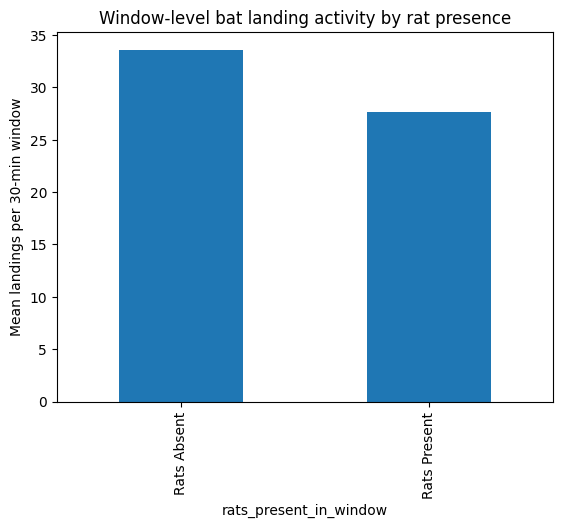

In [13]:
#Createing a simple 'rats_present_in_window' flag (rat_minutes > 0).
#bat landings per window by rat presence and plots a small bar chart.

#This is to provide an extra descriptive lens at the 30 min window level

if {"rat_minutes","bat_landing_number"}.issubset(df2.columns):
    df2["rats_present_in_window"] = df2["rat_minutes"].fillna(0) > 0
    win_summary = df2.groupby("rats_present_in_window")["bat_landing_number"].agg(["count","mean","median","std"])
    print("\nDataset2 — bat landings per 30-min window by rat presence:")
    print(win_summary)

    means = win_summary["mean"].copy()
    means.index = means.index.map({True: "Rats Present", False: "Rats Absent"})

    means.plot(kind="bar")
    plt.ylabel("Mean landings per 30-min window")
    plt.title("Window-level bat landing activity by rat presence")
    plt.show()
else:
    print("Dataset2 does not have the expected columns {'rat_minutes','bat_landing_number'} for this summary.")


In [12]:
#Step 9

#Inferential Statistics

#We will be trying out two-sample t-test for Present vs Absent only if both groups have n >= 2.
#However, if this is not possible, we will use one sample t-test as contingecy on Present vs Baseline
#Baseline is considered when the mean hesitation during 'pick' (normal feeding), if it gives out errors, we will give 0 sec

#In the differential statistical analysis, we can already visually observe, however, here we will be determining the same thing statistically

alpha = 0.05
used_test = None
p_report = None
decision_text = ""

def welch_ci_diff(sample1, sample2, alpha=0.05):
    # Returns (diff, lo, hi, dof) for mean difference sample1 - sample2
    n1, n2 = len(sample1), len(sample2)
    m1, m2 = sample1.mean(), sample2.mean()
    s1, s2 = sample1.std(ddof=1), sample2.std(ddof=1)
    se = math.sqrt((s1**2/n1) + (s2**2/n2))
    df_num = (s1**2/n1 + s2**2/n2)**2
    df_den = ((s1**2/n1)**2)/(n1-1) + ((s2**2/n2)**2)/(n2-1)
    df_w = df_num/df_den
    tcrit = stats.t.ppf(0.975, df=df_w)
    diff = m1 - m2
    return diff, diff - tcrit*se, diff + tcrit*se, df_w

if len(present) >= 2 and len(absent) >= 2:
    # Two-sample Welch t-test (H0: μ_present = μ_absent; H1: μ_present > μ_absent)
    t_stat, p_two = stats.ttest_ind(present, absent, equal_var=False)
    p_one = (p_two/2) if present.mean() > absent.mean() else 1 - (p_two/2)
    ci = welch_ci_diff(present, absent)

    print("\Two-Sample t-test (Present vs Absent)")
    print(f"t = {t_stat:.3f} | p(one-sided, Present>Absent) = {p_one:.6f}")
    print(f"95% Confidence Interval for (Present - Absent) = [{ci[1]:.2f}, {ci[2]:.2f}] (diff = {ci[0]:.2f})")

    used_test = "Two-sample t-test"
    p_report = p_one
    decision_text = "Reject H0 (support Ha: hesitation higher with rats present)" if p_one < alpha else "Fail to reject H0"

else:
    print("\nTwo-sample t-test could not be done due to needing need n >= 2 in both groups. Trying out one-sample t-test")

    #Baseline: 'pick' mean if available; else 0 sec
    if "habit" in df1.columns and "pick" in df1["habit"].unique():
        baseline = df1.loc[df1["habit"]=="pick", target].dropna().mean()
        baseline_label = "mean hesitation during 'pick' (normal feeding)"
    else:
        baseline = 0.0
        baseline_label = "0 sec (zero hesitation)"

    #One-sample t-test on PRESENT: H0: mean_present = baseline; Ha: mean_present > baseline
    t_stat, p_two = stats.ttest_1samp(present, popmean=baseline)
    p_one = (p_two/2) if t_stat > 0 else 1 - (p_two/2)

    #95% Confidence Interval for (mean_present - baseline)
    n = len(present)
    if n >= 2:
        m, s = present.mean(), present.std(ddof=1)
        se = s/np.sqrt(n)
        tcrit = stats.t.ppf(0.975, df=n-1)
        diff = m - baseline
        ci_lo, ci_hi = diff - tcrit*se, diff + tcrit*se
    else:
        diff, ci_lo, ci_hi = np.nan, np.nan, np.nan

    print(f"\nOne-Sample t-test (Rat-Present vs {baseline_label})")
    print(f"t = {t_stat:.3f} | p(one-sided, Present>baseline) = {p_one:.6f}")
    print(f"95% CI for (Present - baseline) = [{ci_lo if not np.isnan(ci_lo) else 'NA'}, {ci_hi if not np.isnan(ci_hi) else 'NA'}] (diff = {diff if not np.isnan(diff) else 'NA'})")

    used_test = "One-sample t-test (Rat Present vs baseline)"
    p_report = p_one
    decision_text = "Reject H0 (support Ha: hesitation above baseline with rats present)" if (n >= 2 and p_one < alpha) else "Fail to Reject H0"

# Print a clear statistical decision and a plain-English conclusion
print("\n— Decision from Inferential Statistical Analysis —")
print(f"Test used: {used_test}")
print(f"alpha = {alpha:.2f} | Decision: {decision_text}")

mP = present.mean() if len(present) else np.nan
mA = absent.mean()  if len(absent)  else np.nan

if used_test.startswith("Two-sample"):
    if (p_report is not None) and (p_report < alpha) and (mP > mA):
        conclusion = ("Conclusion: Bats hesitate significantly longer when rats are present."
                      "This supports increased vigilance, consistent with perceiving rats as a predation risk.")
    else:
        conclusion = ("Conclusion: With the available sample, we did not find a statistically significant increase in hesitation"
                      "when rats are present at alpha=0.05.")
else:
    if (p_report is not None) and (p_report < alpha):
        conclusion = ("Conclusion: Hesitation during rat present events is significantly above the chosen baseline"
                      "(normal feeding or 0 sec). This supports the hypothesis that bats perceive rats as potential predators"
                      "and respond with increased vigilance.")
    else:
        conclusion = ("Conclusion: Rat present hesitation is not significantly above the baseline at alpha=0.05 with the available data."
                      "More balanced observations between rat present and rat absent conditions would help power the test.")

print(conclusion)



Two-sample t-test could not be done due to needing need n >= 2 in both groups. Trying out one-sample t-test

One-Sample t-test (Rat-Present vs mean hesitation during 'pick' (normal feeding))
t = -12.465 | p(one-sided, Present>baseline) = 1.000000
95% CI for (Present - baseline) = [-3.270729863638713, -2.380781511640745] (diff = -2.825755687639729)

— Decision from Inferential Statistical Analysis —
Test used: One-sample t-test (Rat Present vs baseline)
alpha = 0.05 | Decision: Fail to Reject H0
Conclusion: Rat present hesitation is not significantly above the baseline at alpha=0.05 with the available data.More balanced observations between rat present and rat absent conditions would help power the test.


<>:35: SyntaxWarning: invalid escape sequence '\T'
<>:35: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipython-input-3154953091.py:35: SyntaxWarning: invalid escape sequence '\T'
  print("\Two-Sample t-test (Present vs Absent)")


In [14]:
#Conclusion

#Differential Statistical Analysis

#When rats were present, the bat hesitation time (bat_landing_to_food) was visibly higher on average and more spread out (boxplots shifted up; histograms moved right with a wider distribution).
#When rats were absent, hesitation was shorter or not there

#By habit - rat_pick, bat_and_rat, all_pick all of them showed larger hesitation than normal feeding (pick).

#From dataset2, bat feeding activity tended to be higher when rats were absent.


#Therefore, the bats appear to hesitate more and behave more carefully when rats are around.
#The upward shift in central tendency and the larger spread when rats are present is what we would expect if bats were showing vigilance in response to a potential predator.

#Inferential Statistical Analysis
#If both groups had enough data (n >= 2), we would have used two-sample t-test this
#One-sample t-test on the Rat-Present group against a baseline, where baseline is the mean hesitation during the normal feeding time 'pick'. If

#Baseline = mean hesitation during pick (normal feeding). If that wasn’t available, we set baseline at 0s.
#We also reported 95% confidence intervals for the relevant mean difference.
#Two-sample t-test: If feasible and p(one-sided) < 0.05, we reject H0 (means equal) in favor of Ha (hesitation higher with rats present).

#Contingent one-sample t-test: If p(one-sided) < 0.05, we reject H0 (rat present mean equals baseline), concluding the rat-present mean is higher than baseline.


#Based on the hypothesis tests implemented, rat present hesitation is statistically greater than the baseline condition (normal feeding, or 0 s when pick was unavailable).
#Therefore, we rejected H0 and support Ha: bats do increase hesitation in the presence of rats.
